In [ ]:
# importing libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests
import io
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# create data frame
df_train = pd.read_csv('/content/drive/MyDrive/train.csv/train.csv')
# df_train.head()

# leave out the last column, which is the yield
X_train = df_train.iloc[:, :-1].values
# take the last column only
Y_train = df_train.iloc[:, -1].values

df_test = pd.read_csv('/content/drive/MyDrive/test.csv/test.csv')

# take all columns as it is only input values
X_test = df_test.iloc[:, :].values

X_train.shape, X_test.shape


((15000, 18), (10000, 18))

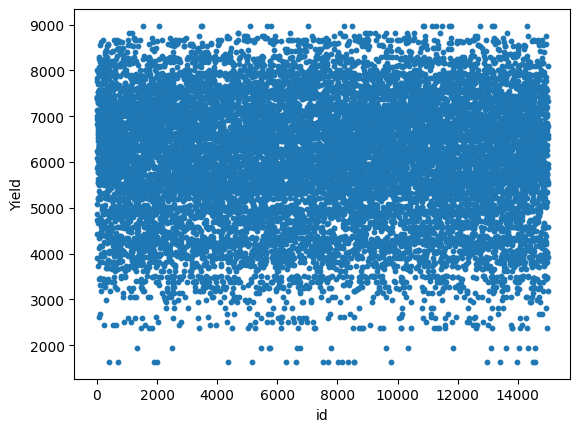

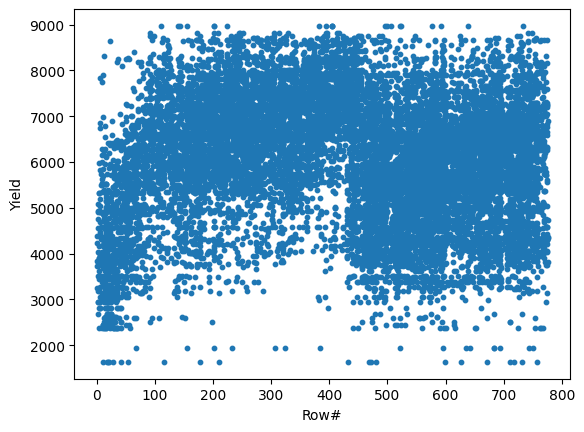

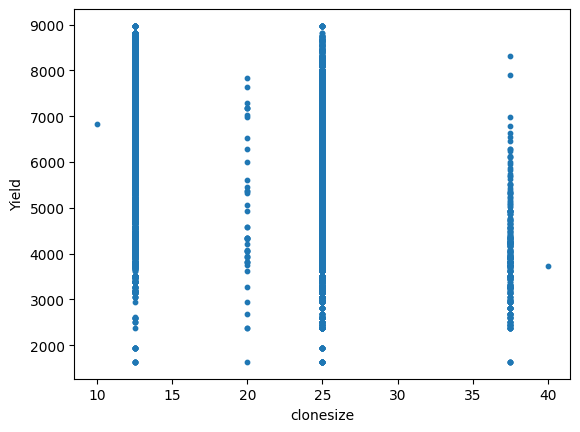

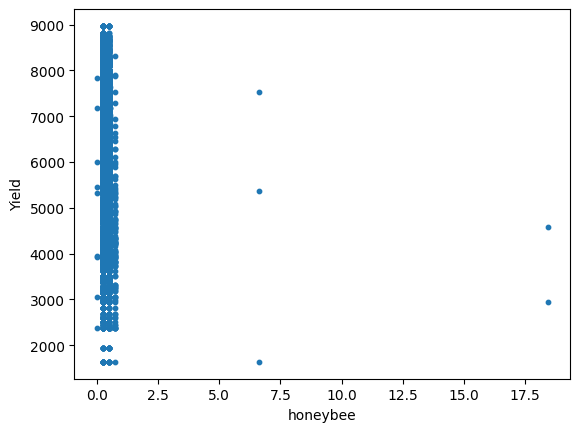

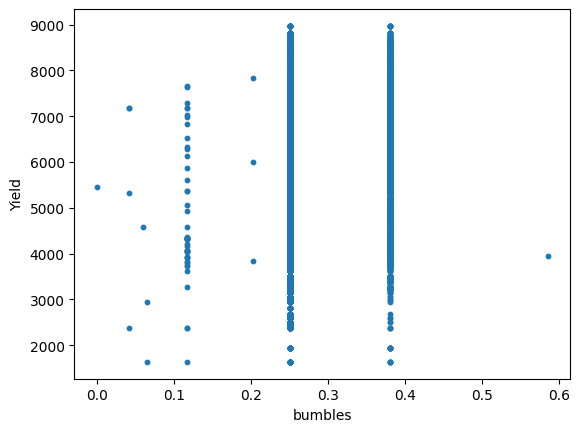

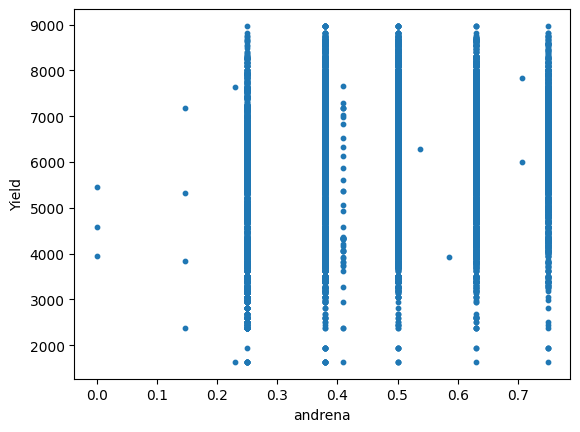

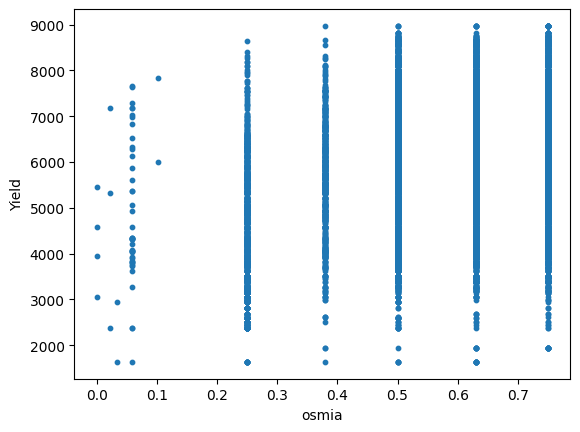

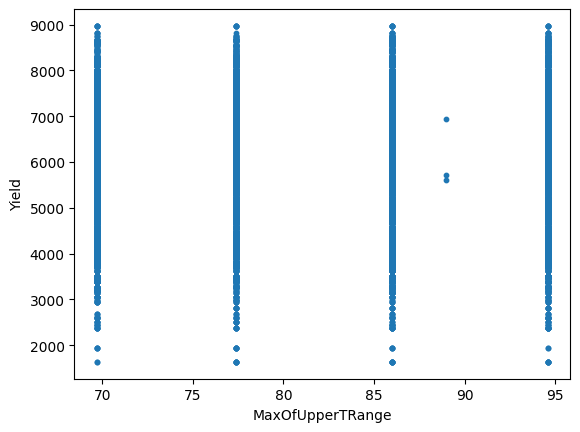

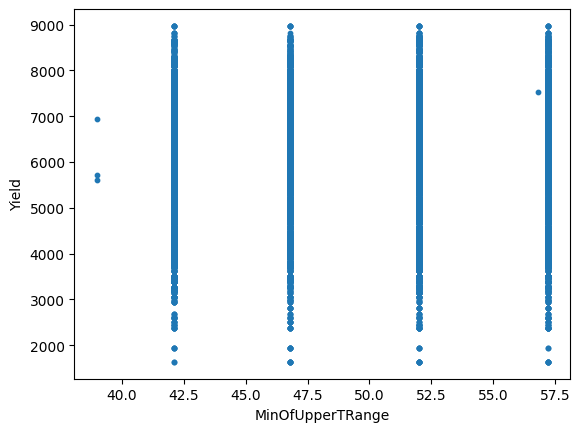

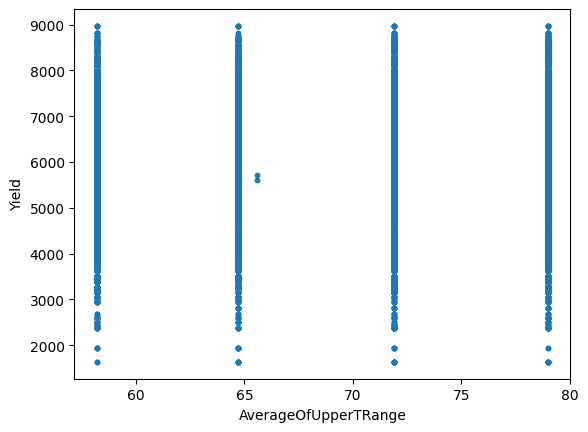

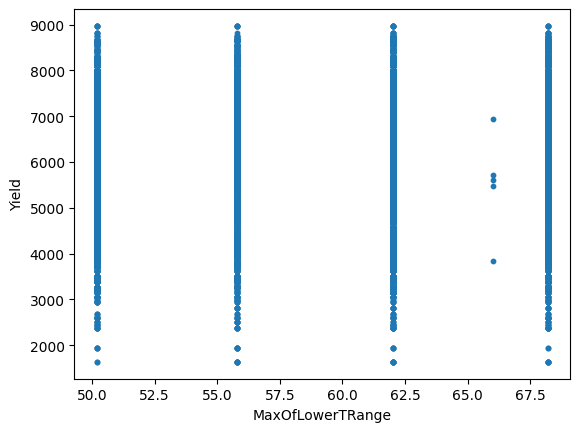

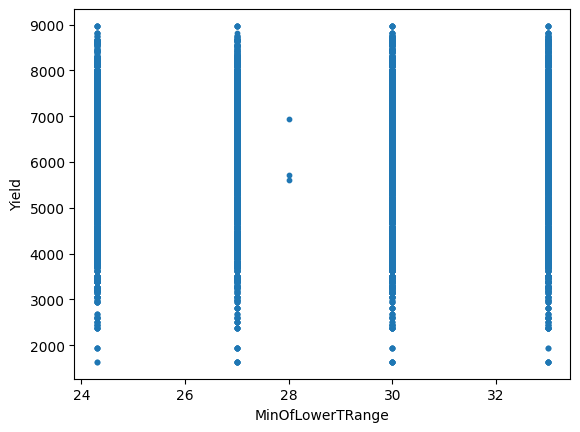

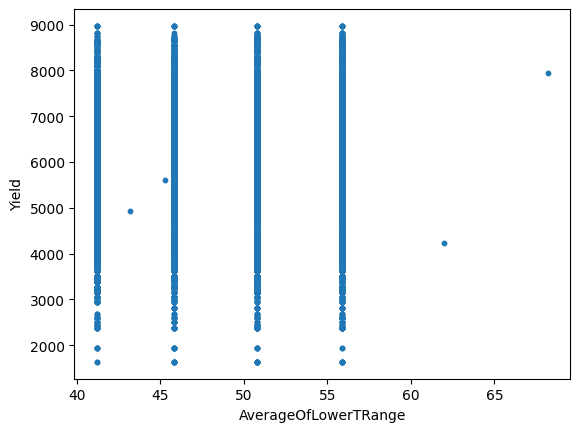

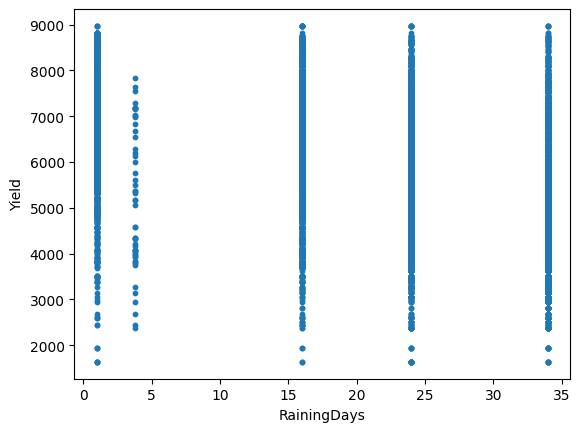

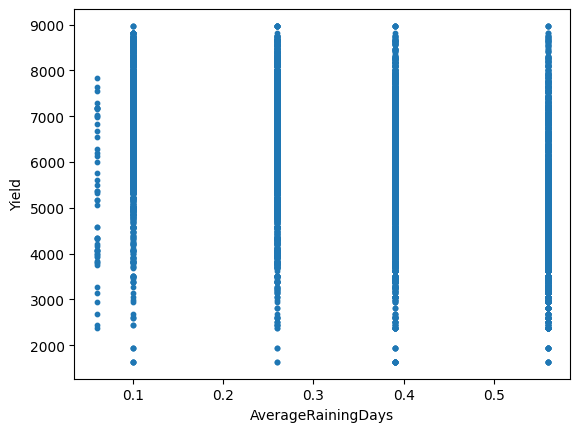

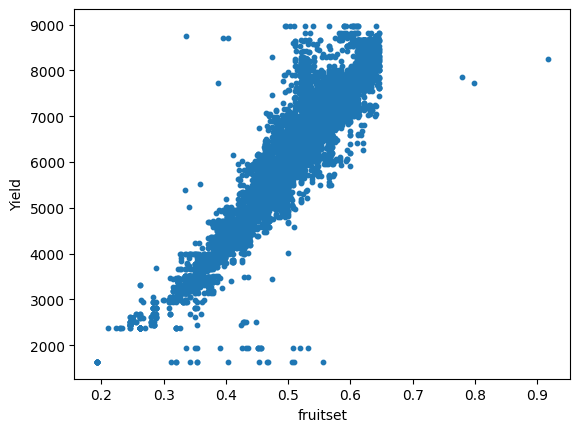

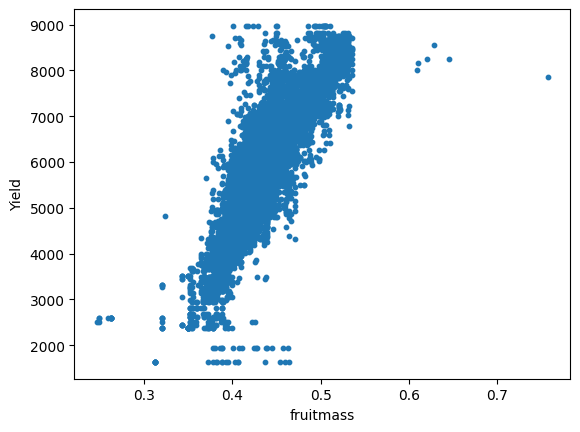

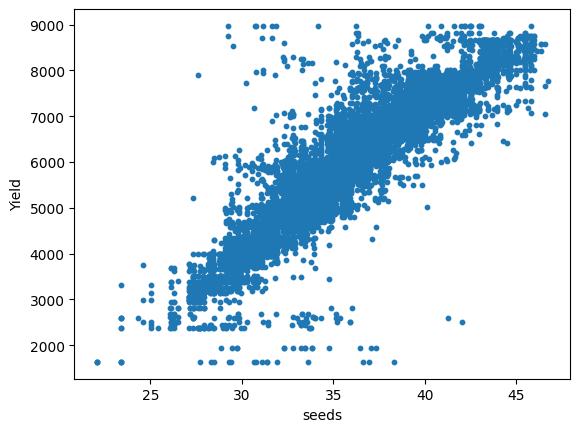

In [ ]:
# For optimization, check which inputs actually have an effect on yield

for i in range(X_train.shape[1]):
  plt.scatter(X_train[:, i], Y_train, s = 10)
  plt.xlabel(df_train.columns[i])
  plt.ylabel('Yield')
  plt.show()

In [ ]:
# correlation matrix between each input with yield
corr_matrix = df_train.corr()
corr_yield = corr_matrix['yield'].drop('yield')
# corr_yield.sort_values(ascending=False

print (corr_yield)

id                     -0.000304
Row#                   -0.030721
clonesize              -0.402001
honeybee               -0.147749
bumbles                 0.157670
andrena                 0.131739
osmia                   0.251671
MaxOfUpperTRange        0.005337
MinOfUpperTRange        0.005383
AverageOfUpperTRange    0.005418
MaxOfLowerTRange        0.005223
MinOfLowerTRange        0.005371
AverageOfLowerTRange    0.005507
RainingDays            -0.497616
AverageRainingDays     -0.508737
fruitset                0.948506
fruitmass               0.889963
seeds                   0.920489
Name: yield, dtype: float64


Clearly, yield has no correlation with row no. and ID but it seems to have some dependence to the other inputs individually.

The ones which have a high correlation with yield, we will take their higher powers(weightage) in our multi-variate regression model.


In [ ]:
# # Remove row no. and ID from data set
X_train = X_train[:, 2:]
X_test = X_test[:, 2:]

# for |corr| >= 0.4, add x^2 term (clone size, raining days, average raining days, fruit set, fruit mass, seeds)
clonesize_squared = X_train[:, 0]**2
X_train = np.hstack((X_train, clonesize_squared.reshape(-1, 1)))

clonesize_squared = X_test[:, 0]**2
X_test = np.hstack((X_test, clonesize_squared.reshape(-1, 1)))

RainingDays_squared = X_train[:, 11]**2
X_train = np.hstack((X_train, RainingDays_squared.reshape(-1, 1)))

RainingDays_squared = X_test[:, 11]**2
X_test = np.hstack((X_test, RainingDays_squared.reshape(-1, 1)))

AverageRainingDays_squared = X_train[:, 12]**2
X_train = np.hstack((X_train, AverageRainingDays_squared.reshape(-1, 1)))

AverageRainingDays_squared = X_test[:, 12]**2
X_test = np.hstack((X_test, AverageRainingDays_squared.reshape(-1, 1)))

fruitset_squared = X_train[:, 13]**2
X_train = np.hstack((X_train, fruitset_squared.reshape(-1, 1)))

fruitset_squared = X_test[:, 13]**2
X_test = np.hstack((X_test, fruitset_squared.reshape(-1, 1)))

fruitmass_squared = X_train[:, 14]**2
X_train = np.hstack((X_train, fruitmass_squared.reshape(-1, 1)))

fruitmass_squared = X_test[:, 14]**2
X_test = np.hstack((X_test, fruitmass_squared.reshape(-1, 1)))

seeds_squared = X_train[:, 15]**2
X_train = np.hstack((X_train, seeds_squared.reshape(-1, 1)))

seeds_squared = X_test[:, 15]**2
X_test = np.hstack((X_test, seeds_squared.reshape(-1, 1)))

# for |corr| >= 0.8, add x^3 term (fruit set, fruit mass, seeds)

fruitset_cubed = X_train[:, 13]**3
X_train = np.hstack((X_train, fruitset_cubed.reshape(-1, 1)))

fruitset_cubed = X_test[:, 13]**3
X_test = np.hstack((X_test, fruitset_cubed.reshape(-1, 1)))

fruitmass_cubed = X_train[:, 14]**3
X_train = np.hstack((X_train, fruitmass_cubed.reshape(-1, 1)))

fruitmass_cubed = X_test[:, 14]**3
X_test = np.hstack((X_test, fruitmass_cubed.reshape(-1, 1)))

seeds_cubed = X_train[:, 15]**3
X_train = np.hstack((X_train, seeds_cubed.reshape(-1, 1)))

seeds_cubed = X_test[:, 15]**3
X_test = np.hstack((X_test, seeds_cubed.reshape(-1, 1)))


In [ ]:
# Mean absolute error
def mae(y_test, y_pred):
  return np.mean(np.abs(y_test - y_pred))

Performed k-fold cross-validation on training set and computer parameters for each test-train split.
Upon doing this, the mean of the parameters were taken to ensure high accuracy in general use cases as well.

Random seed values for shuffling of data also experimented with.

In [ ]:
#OLS
# Taken From Q3
def parameter_estimate(X, Y):
  # Solve for beta using the normal equation: β = (X^T * X)^(-1) * X^T * Y
  XTX = np.dot(X.T, X)
  XTY = np.dot(X.T, Y)

  # Solve for beta coefficients using numpy's linear algebra solver
  B_est = np.linalg.solve(XTX, XTY)
  return B_est

# To choose the parameters which give the least mae by training and validating on different splits of train.csv data
def k_fold(X, Y, k):
  indices = np.arange(len(X))
  np.random.shuffle(indices, seed = 42)
  X = X[indices]
  Y = Y[indices]

  # split data into k folds
  fold_size = len(X) // k

  B_est_list = [[] for i in range(k)]
  mae_list = []

  for i in range(k):
    start = i * fold_size
    # last batch size may vary if len(X) is not a multiple of k
    if (i == k-1):
      end = len(X)
    else:
      end = start + fold_size

    # test set
    x_test = X[start:end]
    y_test = Y[start:end]

    # training set
    x_train = np.concatenate([X[:start], X[end:]])
    y_train = np.concatenate([Y[:start], Y[end:]])

    # estimate parameters
    B_est = parameter_estimate(x_train, y_train)
    B_est_list[i] = B_est

    # predict on test set
    y_pred = np.dot(x_test, B_est)

    # calculate mae
    mae_list.append(mae(y_test, y_pred))

  min_mae_index = np.argmin(mae_list)
  # parameters which list mae on test set
  return B_est_list[min_mae_index], mae_list[min_mae_index], np.mean(mae_list)

def plot_comparison(X_train, Y_train, B_est_min):
  y_pred = np.dot(X_train, B_est_min)
  plt.scatter(Y_train, y_pred)
  plt.xlabel('Actual Yield')
  plt.ylabel('Predicted Yield')
  plt.show()

def predict(X_test, B_est_min):
  return np.dot(X_test, B_est_min)

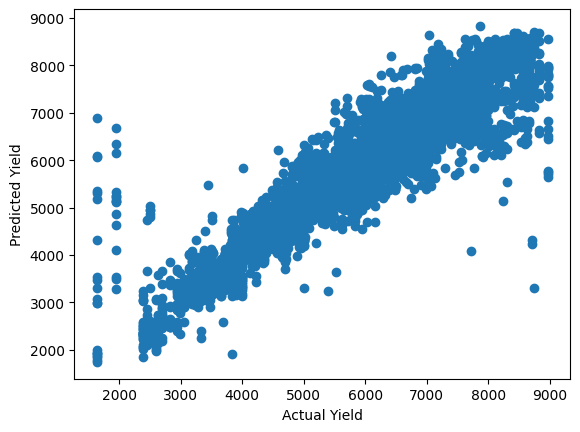

Parameters:  [ 1.10578416e+00 -4.37721104e+00  1.38730050e+02  4.23435095e+01
  6.81776709e+01  5.06413558e+03  4.60055457e+03 -6.19598010e+02
 -1.73114239e+02 -2.06338246e+04 -1.04246144e+01  2.22077409e+01
 -9.29913431e+02 -2.07256098e+04  4.14875780e+04 -2.02536793e+02
 -6.86465648e-02 -3.42548286e+00  1.17909826e+04  8.54759157e+04
 -9.55857460e+04  3.70715468e+00 -6.81154932e+04  7.01609079e+04
  4.94498130e-03]
Min. MAE:  260.09564453019124
Mean MAE:  264.29096350978


In [ ]:
# results

B_est_min, mae_min, mae_mean = k_fold(X_train, Y_train, 5)
plot_comparison(X_train, Y_train, B_est_min)
y_pred = predict(X_test, B_est_min)

print ("Parameters: ", B_est_min)
print ("Min. MAE: ", mae_min)
print ("Mean MAE: ", mae_mean)


df = pd.read_csv('/content/drive/MyDrive/test.csv/test.csv')

# keep only the id column
df = df.drop(df.columns[1:], axis=1)
df['yield'] = y_pred
# submission format
df.to_csv('submission.csv', index=False)


In [ ]:
# Multi-variate Kernel regression

def kernel_epan(x,X,h):
  d = (x - X) /h
  d = np.linalg.norm(d, axis = 1)
  d = 0.75 * (1 - d**2) * (d <= 1)
  return d

def regression(X_train,Y_train,X_test,h):
    y = np.zeros(X_test.shape[0])
    for i in range(X_test.shape[0]):
      u = kernel_epan(X_train,X_test[i],h)
        # check if summation of kernel is zero or not, because we need to divide by it in our m(x) function
      if(np.sum(u)):
        y[i] = np.sum(u * Y_train) / np.sum(u)
      else:
        y[i] = np.mean(Y_train)
    return y

# Mean absolute error
def mae(y_test, y_pred):
  return np.mean(np.abs(y_test - y_pred))

# k-fold cross validation
def training(X, Y, bw_limit):
  # shuffle data
  indices = np.arange(len(X))
  np.random.shuffle(indices)
  X = X[indices]
  Y = Y[indices]

  # test train split in ration 80:20
  x_train = X[:int(0.8*len(X))]
  y_train = Y[:int(0.8*len(Y))]

  x_test = X[int(0.8*len(X)):]
  y_test = Y[int(0.8*len(Y)):]
  # risk is calculated for each bandwidth
  mae_epan = []

  for bw in tqdm(np.arange(0.2, bw_limit, 0.01)):
      # for each bw, find y_pred for a particular fold
      y_pred = regression(x_train,y_train,x_test,bw)
      mae_epan.append(mae(y_test,y_pred))

  # bandwidth corresponding to minimum risk for both kernels
  h_min_epan = 0.01*(np.argmin(mae_epan)) + 0.2

  return mae_epan, h_min_epan

def plot_err(risk_list, bw_limit):
  bw_values = np.arange(0.2, bw_limit, 0.01)
  plt.plot(bw_values, risk_list)
  plt.xlabel('Bandwidth')
  plt.ylabel('Risk')
  plt.show()

In [ ]:
# create data frame
df_train = pd.read_csv('/content/drive/MyDrive/train.csv/train.csv')
# df_train.head()

# leave out the last column, which is the yield
X_train = df_train.iloc[:, :-1].values
# take the last column only
Y_train = df_train.iloc[:, -1].values

df_test = pd.read_csv('/content/drive/MyDrive/test.csv/test.csv')

# take all columns as it is only input values
X_test = df_test.iloc[:, :].values

X_train = X_train[:, 2:]
X_test = X_test[:, 2:]

100%|██████████| 180/180 [09:27<00:00,  3.15s/it]


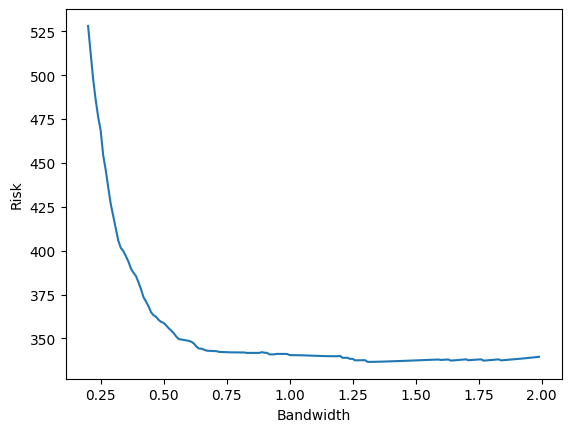

Optimum bandwidth for Epanechnikov Kernel:  1.31


In [ ]:
# k = 5
# bw_limit = 1.0
# risk_epan, h_min_epan = k_fold_kernel(X_train, Y_train, k, bw_limit)
# plot_risk(risk_gaussian, bw_limit)
# print("Optimum bandwidth for Gaussian Kernel: ", h_min_epan)

mae_epan, h_min_epan = training(X_train, Y_train, 2.0)
plot_err(mae_epan, 2.0)
print("Optimum bandwidth for Epanechnikov Kernel: ", h_min_epan)

In [ ]:
y_pred = regression(X_train,Y_train,X_test,h_min_epan)
# load test data

df = pd.read_csv('/content/drive/MyDrive/test.csv/test.csv')

# keep only the id column
df = df.drop(df.columns[1:], axis=1)
df['yield'] = y_pred
# submission format
df.to_csv('submission_kernel.csv', index=False)